In [12]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import IPython
from scipy.signal import spectrogram, buttord, butter, lfilter, freqz, tf2zpk

## Základy
Pracujeme s nahrávkou *xbartu11.wav*, kterou pomocí knihovní funkce *wavfile* načteme. Tato funkce vrací vzorkovací frekvenci a pole hodnot. Počet prvků v poli nám udává počet vzorků. Pokud počet vzorků podělíme vzorkovací frekvencí, tak dostaneme délku nahrávky v sekundách. Pomocí funkce max() a min () zjistíme nejmenší hodnoty v poli respektive vzorků.

Získané výsledky:
Délka ve vzorcích je: 43316
Délka v sekundách je: 2.70725[s]
Nejmenší hodnota je: -2173
Největší hodnota je: 2413


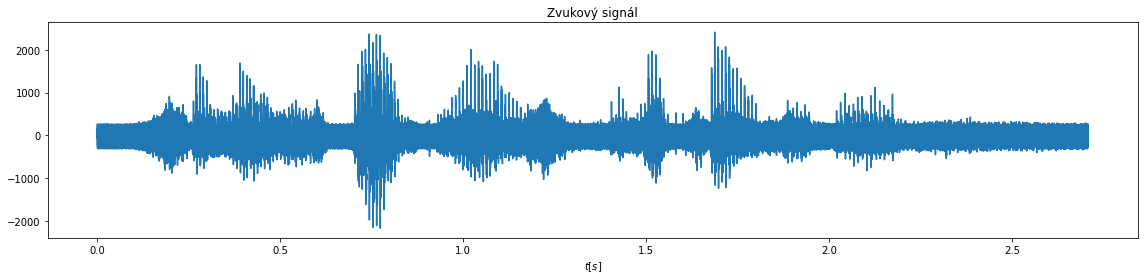

In [13]:
samplingFrequency, data = wavfile.read("xbartu11.wav")

# Pocet vzorku vydelime vzorkovaci frekvenci a tim ziskame delku nahravky v sekundach
wavLen = data.size / samplingFrequency

# Najdeme nejmensi a nejvetsi hodnotu
min_val = min(data)
max_val = max(data)

t = np.arange(data.size) / samplingFrequency

print("Získané výsledky:")
print("Délka ve vzorcích je: " + str(data.size))
print("Délka v sekundách je: " + str(wavLen) + "[s]")
print("Nejmenší hodnota je: " + str(min_val))
print("Největší hodnota je: " + str(max_val))

plt.figure(figsize=(16,4))
plt.plot(t, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')
plt.tight_layout()

## Předzpracování a rámce
Střední hodnotu z dat jsme vypočítali pomocí vzorce $\frac{1}{n}\sum_{i=1}^{n}x_i$, kterou jsme následně odečetli od dat. Normalizaci jsme provedli pomocí následujícího příkazu

`data = data / max(abs(min_val), max_val)`

data jsme následně s překrytím 512 vzorků uložily jako řádkový vektor, z kterého jsme následně pomocí funkce *resize* udělali matici o 1024 sloupcích. Díky tomuto jsme mohli lehce prohlížet jednotlivé rámce a mohli najít pěkný znělý rámec.

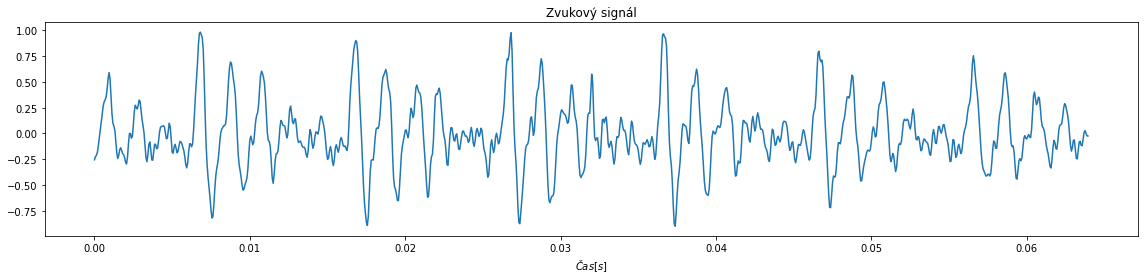

In [14]:
# Vypocet stredni hodnoty
stredniHodnota = np.sum(data) / data.size

data = data - stredniHodnota

# normalizace
data = data / max(abs(min_val), max_val)

# rozdelime data
i = 512
rowCounter = 0
vector = np.array([])
while i < data.size:
    start = 0
    i-=512
    for start in range(1024):
        if i >= data.size:
            break
        vector = np.append(vector, data[i])
        i+=1
    rowCounter+=1

# prevedeme vektor na matici
vector.resize((rowCounter, 1024))

# vybereme pekny ramec
vzorek = np.array([])
vzorek = np.append(vzorek, vector[23])

#jak dlouhy je signal
t = np.arange(vzorek.size) / samplingFrequency

# graf po normalizaci
plt.figure(figsize=(16,4))
plt.plot(t, vzorek)
plt.gca().set_xlabel('$Čas[s]$')
plt.gca().set_title('Zvukový signál');
plt.tight_layout()

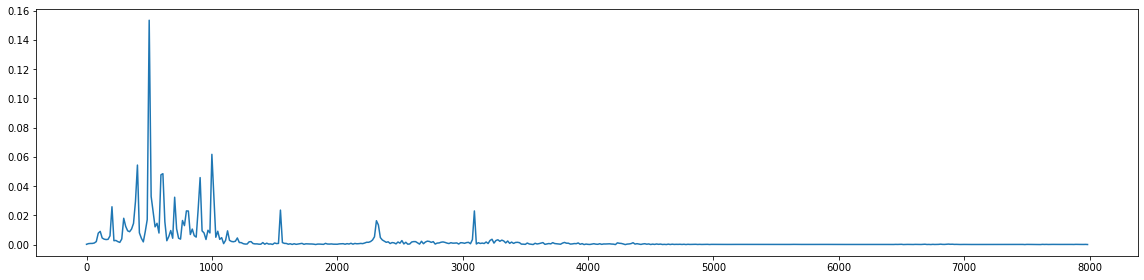

In [15]:
# TENTO KOD JE PRO VYPRACOVANI PROJEKTU NEPOTREBNY A SLOUZI VYHRADNE JAKO KONTROLA VLASTNI IMPLEMENTACE DFT
fourierTransform = np.fft.fft(vzorek)/len(vzorek)
fourierTransform = fourierTransform[range(int(len(vzorek)/2))]

tpCount = len(vzorek)
values = np.arange(int(tpCount)/2)
timePeriod = tpCount/samplingFrequency
frequencies = values/timePeriod

plt.figure(figsize=(16,4))
plt.plot(frequencies,abs(fourierTransform));
plt.tight_layout()
############################################################################################################

## DFT
Při implementaci vlastní diskrétní Fourierovy transformace vychazíme ze vzorce $X´[k]=X[k] * e^{-j\frac{2\pi}{N}kn}$ kde $X[k]$ je původní signál a $e^{-j\frac{2\pi}{N}kn}$ je hodnota, kterou budeme signál násobit. Respektive, protože pracujeme vektorově tak budeme maticově násobit.

Vstupem vlastní funkce DFT je vektor hodnot. Z něho si pomoci funkce *len( )* zjitíme parametr *N*, následně vytvoříme řádkový vektor *n* a sloupcový vektor *k*, které nabývají hodnot od 0 po *N-1*. Díky tomu nám po vynásobení vznikne čtvercová matice *$N*N$*. Následně pak maticově vynásobíme vektor na vstupu funkce s námi vypočítanou maticí pomocí binárního operátoru *@* Výsledkem bude řádkový vektor, který následně vrátíme.

DFT chceme zobrazit od 0 do $\frac{F_s}{2}$ tudíž z vektoru, který jsme dostali z *DFT( )* potřebujeme jen dolní polovinu dat, tudíž pomoci *range* odstraníme horní polovinu dat. Následně vytvoříme vektor frekvencí na kterých jsou jednotlivá data a nakonec zobrazíme graf.


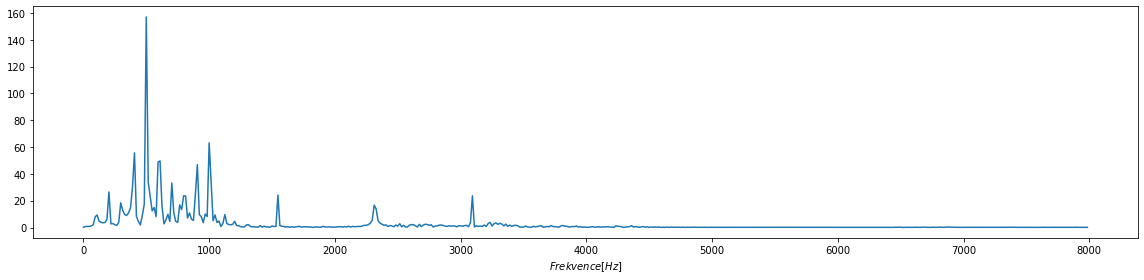

In [16]:
def DFT(x):
    n = np.arange(len(x))
    k = n.reshape((len(x),1))
    e = np.exp(-2j * np.pi * k * n / len(x))
    X = x @ e
    return X

X = DFT(vzorek)
# chceme zobrazit jen pulku dat
X = X[range(int(len(vzorek)/2))]

# prepocitame frekvenci abychom ji mohli zobrazit
N = len(X)
n = np.arange(N)
T = N/samplingFrequency
freq = n/T

plt.figure(figsize=(16,4))
plt.plot(freq/2, abs(X));
plt.gca().set_xlabel('$Frekvence[Hz]$')
plt.tight_layout()

## Spektrogram

Pro zobrazení spektrogramu jsme využili funci *spectrogram()*. Tato funkce vnitřně implementuje *fft*. Pomocí parametru *nperseg=1024* jsme nastavili délku segmentu a pomocí *noverlap=512* překrytí segmentu. Následně jsme vzorky signálu upravili logaritmickou funkcí $P[k]=10*\log_{10}\lvert X[k] \rvert^2$

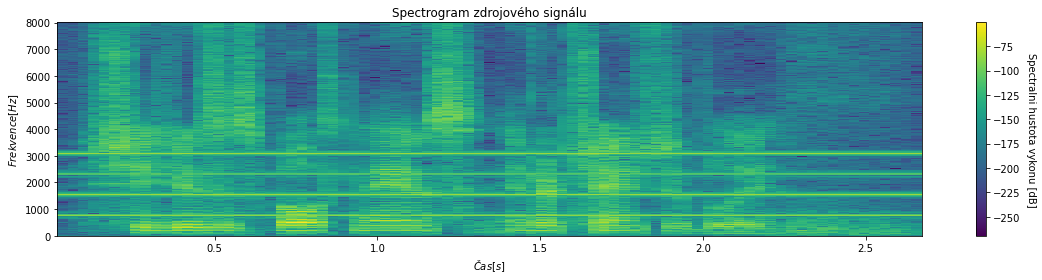

In [17]:
f, t, sgr = spectrogram(data, samplingFrequency, nperseg=1024, noverlap=512, nfft=1024)
sgr_log = 10 * np.log10(abs((sgr+1e-20))**2)

plt.figure(figsize=(16,4))
plt.pcolormesh(t,f, sgr_log, shading='auto')
plt.gca().set_xlabel('$Čas [s]$')
plt.gca().set_ylabel('$Frekvence [Hz]$')
plt.gca().set_title('Spectrogram zdrojového signálu')
cbar = plt.colorbar()
cbar.set_label('Spectralni hustota vykonu [dB]', rotation=270, labelpad=15)
plt.tight_layout()

## Určení rušivých frekvencí
Ručně pomocí zmenšování rozsahu na ose y jsme odhadly rušivé frekvence a to následující:

$f_4 = 3094$
    
$f_3 = 2320.5$

$f_2 = 1547$

$f_1 = 773.5$

Nyní oveříme zda jsou frekvence $f_4, f_3, f_2$ násobky té nejnižší respektive $f_1$

$f_4: \frac{f_4}{f_1} = \frac{3094}{773.5} = 4$

$f_3: \frac{f_3}{f_1} = \frac{2320.5}{773.5} = 3$

$f_2: \frac{f_2}{f_1} = \frac{1547}{773.5} = 2$

## Generování signálu
Pomocí již zjištěných frekvení $f_4, f_3, f_2, f_1$ vytvoříme 4 signály o těchto frekvencích, které sečteme dohromady. Signály jsou vytvořeny z následujícího vzorce: $y[k] = cos(2\pi ft)$
Zobrazíme spektrogram pomocí funkce zmíněné výše. Předtím než uložíme signál tak ho znormalizujeme. Zjistíme normu a následně signál normou podělíme

`norm = np.linalg.norm(cos)`

`norm_cos = cos / norm`

Následně pomocí funkce *wavfile.write()* uložíme signál a tento signál musí mít vzorkovací frekvenci 16kHz, tudíž můžeme použít naší zjištěno a bitová šířka by měla být 16bit a to uděláme následovně.

`wavfile.write("audio/4cos.wav", samplingFrequency, (norm_cos * np.iinfo(np.int16).max).astype(np.int16))`

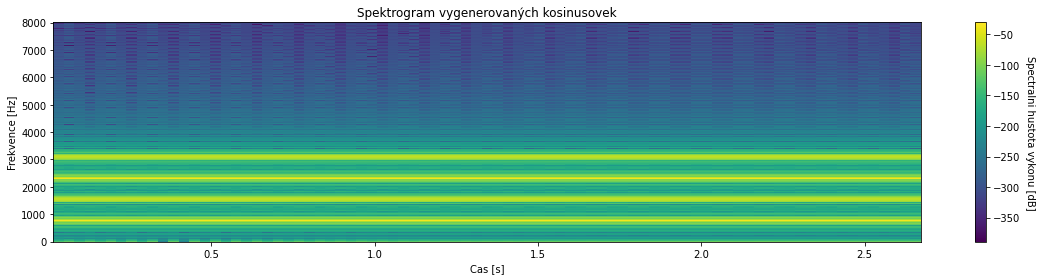

In [18]:
# rozděleni času na vektor aby data odpovidala vzorkovaci frekvenci
t = np.arange(0,wavLen,1.0/samplingFrequency)

f4 = 3094
cos = np.cos(2*np.pi*f4*t)

f3 = 2320.5
cos += np.cos(2*np.pi*f3*t)

f2 = 1547
cos += np.cos(2*np.pi*f2*t)

f1 = 773.5
cos += np.cos(2*np.pi*f1*t)

# kod prevzat a upraven z https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
f, t, Sxx = spectrogram(cos, samplingFrequency, nperseg=1024, noverlap=512, nfft=1024)
Sxx_log = 10 * np.log10((Sxx+1e-20)**2)

plt.figure(figsize=(16,4))
plt.pcolormesh(t, f, Sxx_log, shading='auto')
plt.gca().set_xlabel('Cas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
plt.gca().set_title('Spektrogram vygenerovaných kosinusovek')
cbar = plt.colorbar()
cbar.set_label('Spectralni hustota vykonu [dB]', rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

#zjistíme normu a znormujeme
norm = np.linalg.norm(cos)
norm_cos = cos / norm

#inspirace z https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
wavfile.write("audio/4cos.wav", samplingFrequency, (norm_cos * np.iinfo(np.int16).max).astype(np.int16))

#IPython.display.display(IPython.display.Audio(norm_cos, rate=samplingFrequency))

## Čistící filtr
Čistící filtr je implementován jak 4 pásmové zádrže(bandstop). Pro zjednodušení byla vytvořena funkce *BandStopKoef()*, která má dva paremetry a to frekvenci, kterou chceme eliminovat a vzorkovací frekvenci a funkce nám vrácí koeficinety b, a. Dále byla vytvořena funkce *Filter()*, která má tři parametry a to koeficienty b, a společně s nějakým signálem. V tomto případě se jedná o impulzní odezvu.

### *BandStopKoef()*
V této funkci využíváme funkce *buttord a butter* z knihovny *scipy*, pro správný chod funkce *buttord* bylo třeba vypočítat Nyquistovu frekvenci $\frac{F_s}{2}$ a touto hodnotou bylo třeba podělit data použitá v parametrech viz. následující kód.

`N, Wn = buttord(wp=[(f-15)/nygs, (f+15)/nygs], ws=[(f-15-25)/nygs, (f+15+25)/nygs], gpass=0.5, gstop=5)`

Jednotlivé parametry byly zvoleny tak, aby co možno nejlépe vyčistili signál. Následující funkce *butter* nám pomocí hodnot, které nám vrátila předešlá funkce, vypočíta jednotlivé koeficienty b, a, které následně vrátíme.

### *Filter()*
Tato funkce aplikuje koeficinenty filteru na signál a to díky funkci *lfilter()* z knihovny *scipy* a vrací nám vyfiltrovaný signál, který poslezé také vrátíme.

### Zobrazení impulzní odezvy
Vytoříme si jednotkový impluz, který se pak zobrazí po aplikovaní filtru, respektive po aplikaci funkcí *BandStopKoef()* a *Filter()*. Toto jsme provedli celkem 4 krát a to pro frekvence $f_1, f_2, f_3, f_4$.

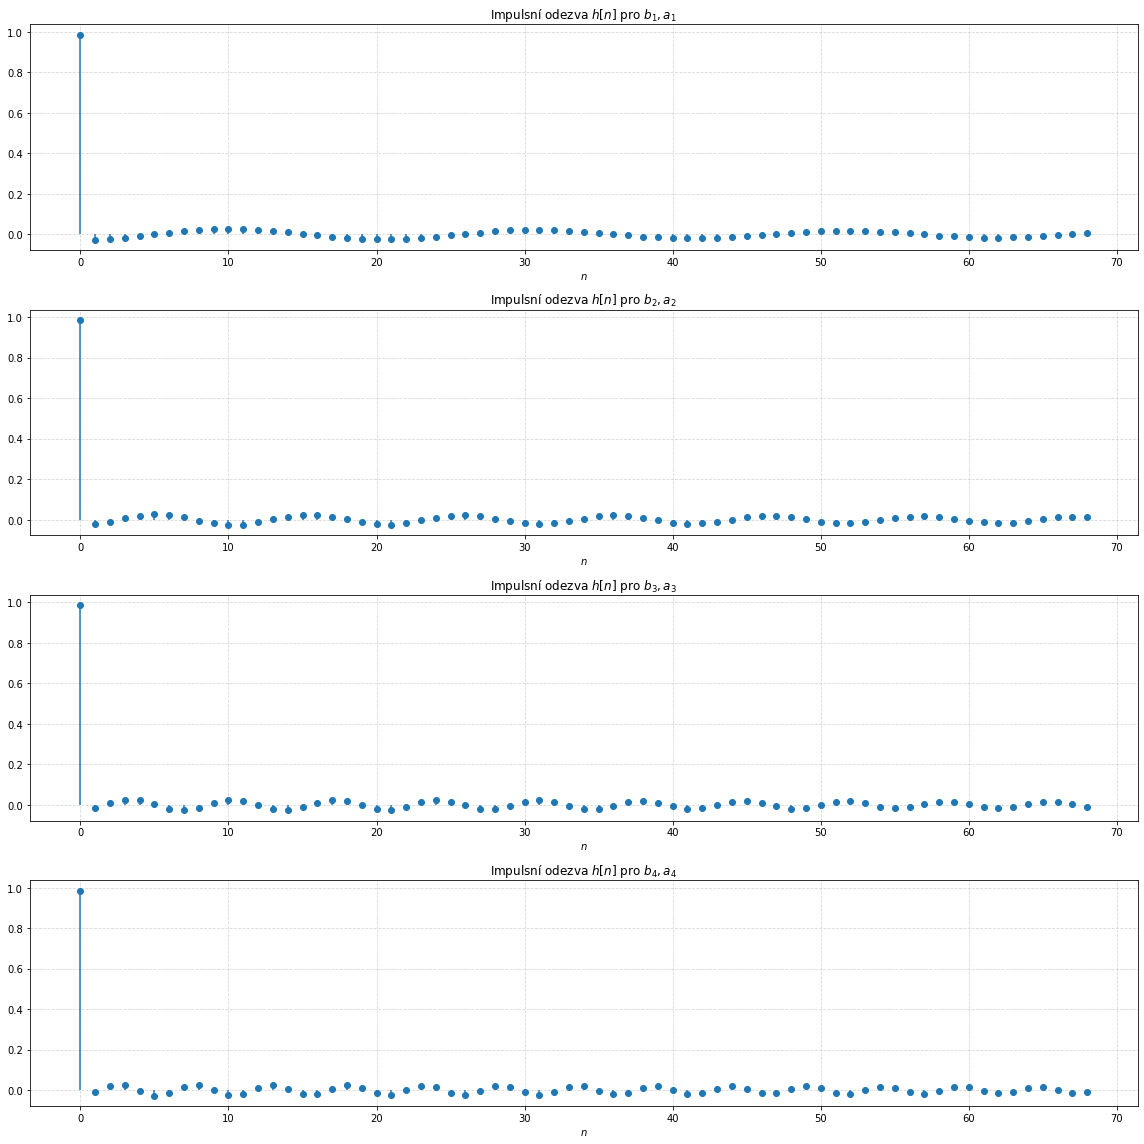

In [19]:
# Zdroje pro vypocet vyfiltrovaneho signalu https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
def BandStopKoef(f, samplingFrequency):
    nygs = samplingFrequency / 2
    N, Wn = buttord(wp=[(f-15)/nygs, (f+15)/nygs], ws=[(f-15-25)/nygs, (f+15+25)/nygs], gpass=0.5, gstop=5)
    b, a = butter(N, Wn, btype='bandstop')
    return  b, a

def Filter(b, a, imp):
    h = lfilter(b, a, imp)
    return h

#impulzni odezva
N_imp = 69
imp = [1 , *np.zeros(N_imp-1)]

_, ax = plt.subplots(4, 1, figsize=(16,16))

b1, a1 = BandStopKoef(f1, samplingFrequency)
h = Filter(b1, a1, imp)
ax[0].stem(np.arange(N_imp), h, basefmt=' ') 
ax[0].set_xlabel('$n$')
ax[0].set_title('Impulsní odezva $h[n]$ pro $b_1, a_1$')

b2, a2 = BandStopKoef(f2, samplingFrequency)
h = Filter(b2, a2, imp)
ax[1].stem(np.arange(N_imp), h, basefmt=' ') 
ax[1].set_xlabel('$n$')
ax[1].set_title('Impulsní odezva $h[n]$ pro $b_2, a_2$')

b3, a3 = BandStopKoef(f3, samplingFrequency)
h = Filter(b3, a3, imp)
ax[2].stem(np.arange(N_imp), h, basefmt=' ') 
ax[2].set_xlabel('$n$')
ax[2].set_title('Impulsní odezva $h[n]$ pro $b_3, a_3$')

b4, a4 = BandStopKoef(f4, samplingFrequency)
h = Filter(b4, a4, imp)
ax[3].stem(np.arange(N_imp), h, basefmt=' ') 
ax[3].set_xlabel('$n$')
ax[3].set_title('Impulsní odezva $h[n]$ pro $b_4, a_4$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

## Nulové body a póly
Protože budeme chtít vypočítat nuly a póly celkem 4 krát tak jsme vytvořili funkci *PolesAndZeros()*, v které se pomocí funkce *tf2zpk* z knihovny vypočítají nuly a póly z koeficientů b, a. Funkce vrací pole nul, pólů a přírustek systému.

Nuly a póly jsme si zobrazily a zjistili jsme, že se zobrazili, pro jednotlive koeficienty $b_i, a_i$ kde i = {1, 2, 3, 4}, sami do sebe.

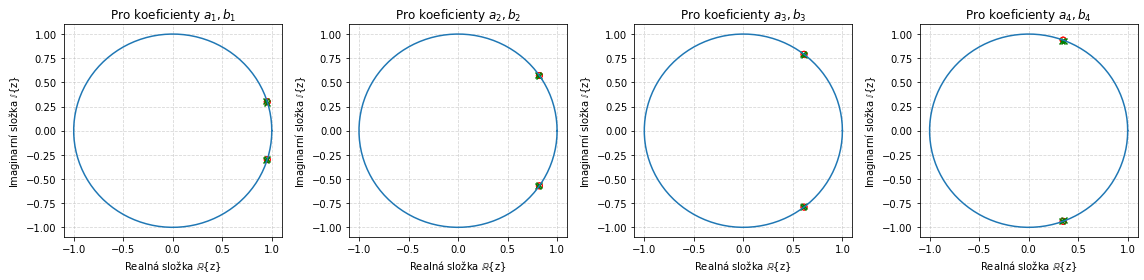

In [20]:
def PolesAndZeros(b, a):
    z, p, k = tf2zpk(b, a)
    return z, p, k

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)

_, ax = plt.subplots(1, 4, figsize=(16,4))

z, p, k = PolesAndZeros(b1, a1)
ax[0].plot(np.cos(ang), np.sin(ang))
ax[0].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[0].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')
ax[0].set_title('Pro koeficienty $a_1, b_1$')
ax[0].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[0].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

z, p, k = PolesAndZeros(b2, a2)
ax[1].plot(np.cos(ang), np.sin(ang))
ax[1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')
ax[1].set_title('Pro koeficienty $a_2, b_2$')
ax[1].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[1].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')


z, p, k = PolesAndZeros(b3, a3)
ax[2].plot(np.cos(ang), np.sin(ang))
ax[2].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[2].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')
ax[2].set_title('Pro koeficienty $a_3, b_3$')
ax[2].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[2].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')


z, p, k = PolesAndZeros(b4, a4)
ax[3].plot(np.cos(ang), np.sin(ang))
ax[3].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[3].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')
ax[3].set_title('Pro koeficienty $a_4, b_4$')
ax[3].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[3].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

## Frekvenční charakteristika
Moduly frekvenční charakteristiky frekvencí $f_1, f_2, f_3, f_4$ jsme zobrazily do jednoho grafu a z něho lze vidět, že by měl filtr skutečně potlačovat frekvence na určených frekvencí a argumenty frekvenční charakteristiky daných frekvencí, tak nám určily, jak se jednotlivé frekvenční složky zpozdí/předběhnou.

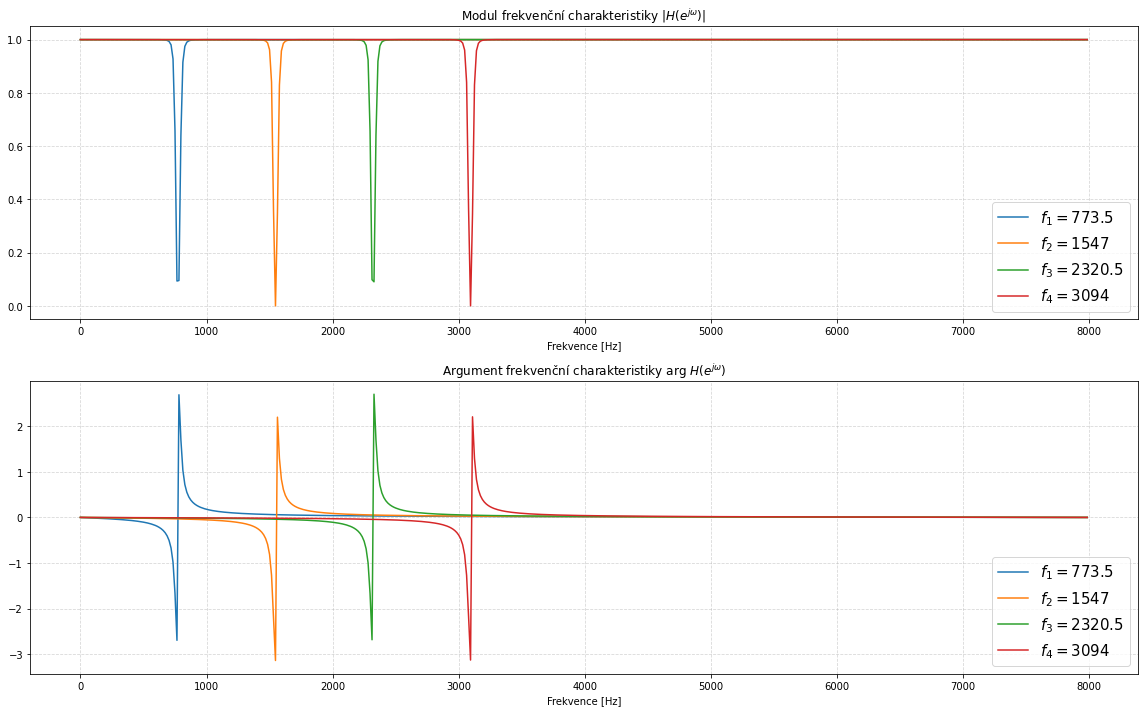

In [21]:
# frekvencni charakteristika
_, ax = plt.subplots(2, 1, figsize=(16,10))

w, H = freqz(b1, a1)
ax[0].plot(w / 2 / np.pi * samplingFrequency, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * samplingFrequency, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')


w, H = freqz(b2, a2)
ax[0].plot(w / 2 / np.pi * samplingFrequency, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * samplingFrequency, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')


w, H = freqz(b3, a3)
ax[0].plot(w / 2 / np.pi * samplingFrequency, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * samplingFrequency, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')


w, H = freqz(b4, a4)
ax[0].plot(w / 2 / np.pi * samplingFrequency, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * samplingFrequency, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

ax[0].legend(('$f_1=773.5$','$f_2=1547$','$f_3=2320.5$','$f_4=3094$' ), prop={'size': 15}, loc='lower right')
ax[1].legend(('$f_1=773.5$','$f_2=1547$','$f_3=2320.5$','$f_4=3094$' ), prop={'size': 15}, loc='lower right')
plt.tight_layout()

## Filtrace
Postupně jsme vyfiltrovali signál pomocí námi již předem zjistěných koeficinetů b, a.

`sf = lfilter(b1, a1, data)`

`sf = lfilter(b2, a2, sf)`

`sf = lfilter(b3, a3, sf)`

`sf = lfilter(b4, a4, sf)`

Pro kontrolu zda byly skutečně rušivé frekvence odstraněny, tak jsme zobrazili spectrogram vyfiltrovaného signálu a také jeho časový průbeh. Je zde vidět, že se nám frekvence podařilo vyfiltrovat kromě počátku audia. Toto "pípnutí" se mi nepodařilo zcela vyfiltrovat ikdyž jsme měnil vlastnosti filtru. Nic méně filtr vyfiltroval rušivé frekvence v podstatě v celém audiu.

Následně vyfiltrovaný signál jsme uložili do souboru stejným způsobem, který byl zmíněn výše.

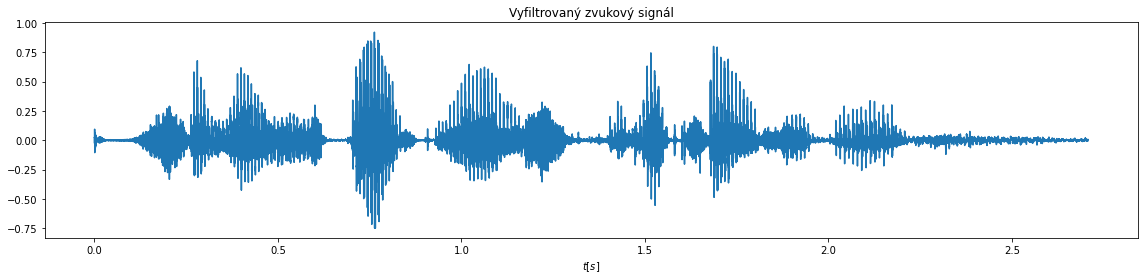

In [22]:
sf = lfilter(b1, a1, data)
sf = lfilter(b2, a2, sf)
sf = lfilter(b3, a3, sf)
sf = lfilter(b4, a4, sf)
f, t, sfgr = spectrogram(sf, samplingFrequency,nperseg=1024, noverlap=512, nfft=1024)
sfgr_log = 10 * np.log10((sfgr+1e-20)**2)

plt.figure(figsize=(16,4))
plt.pcolormesh(t,f,sfgr_log, shading='auto')
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)


t = np.arange(sf.size) / samplingFrequency
plt.figure(figsize=(16,4))
plt.plot(t, sf)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Vyfiltrovaný zvukový signál')
plt.tight_layout()

wavfile.write("audio/clean_bandstop.wav", samplingFrequency, (sf * np.iinfo(np.int16).max).astype(np.int16))

#IPython.display.display(IPython.display.Audio(sf, rate=samplingFrequency))

## Zdroje
https://nbviewer.org/github/zmolikova/ISS_project_study_phase/blob/master/Zvuk_spektra_filtrace.ipynb

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html